In [17]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing.cleaning.text_cleaning import process_text
from eda.token_frequency_analyzer import TokenFrequencyAnalyzer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
init_df = pd.read_csv("../data/raw/quora_question_pairs_train.csv.zip", compression='zip', index_col=0)
pd.set_option('display.max_colwidth', None)

In [4]:
init_df.head(5)

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0
196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0
113125,184949,184950,How useful is MakeUseOf Answers?,"Is there any Q&A site that is not Yahoo answers, where hate speech is allowed?",0
266232,101283,163744,Which is the best place to reside in India and Why?,Which ia the best place to visit in India?,0
122738,17811,27517,Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?,Why don't many people posting questions on Quora check Google first?,1


In [5]:
df = init_df.copy()

In [6]:
df.shape

(323432, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323432 entries, 332278 to 402019
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          323432 non-null  int64 
 1   qid2          323432 non-null  int64 
 2   question1     323431 non-null  object
 3   question2     323430 non-null  object
 4   is_duplicate  323432 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.8+ MB


Спостереження:

Загалом маємо п’ять ознак: три числові (int64) і дві текстові (object).


In [8]:
df.isnull().sum()

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

Спостереження:

Загальна кількість пропущених значень у наборі даних є незначною та зосереджена виключно у текстових полях.

У стовпці question1 виявлено лише 1 пропущене значення, а в question2 — 2 пропущення, що не є критичним зважаючи на обсяг даних. Отже, доцільно буде видалити такі рядки.


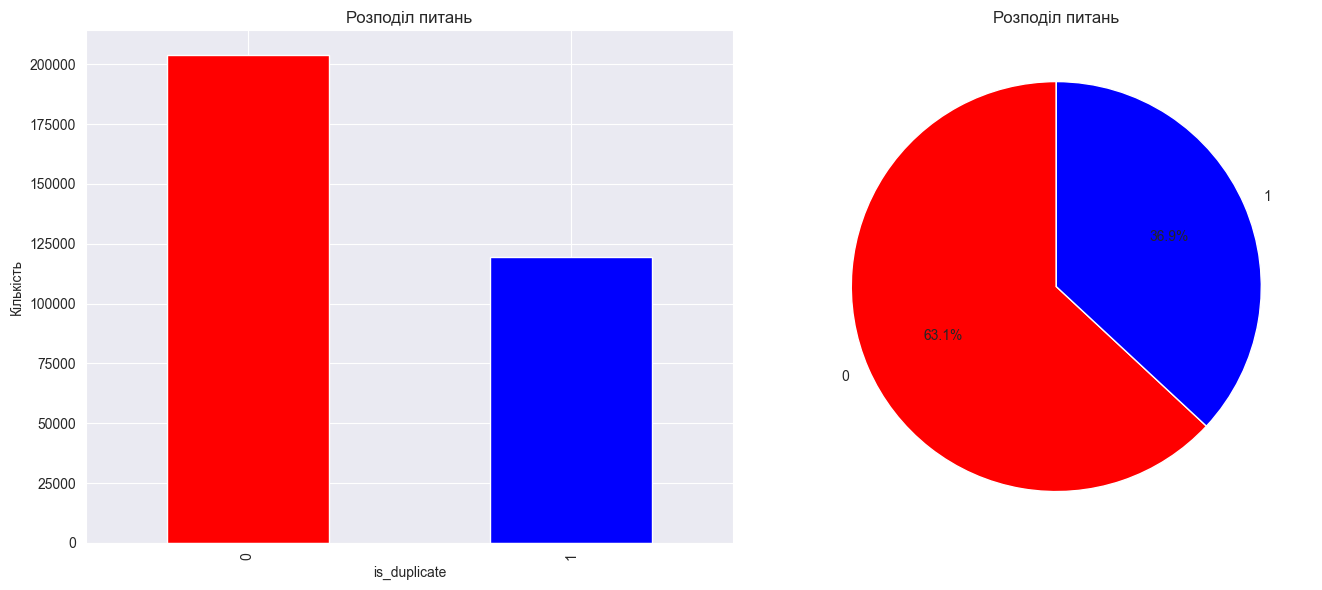

is_duplicate
0    204022
1    119410
Name: count, dtype: int64

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df['is_duplicate'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'blue'])
axes[0].set_title('Розподіл питань')
axes[0].set_xlabel('is_duplicate')
axes[0].set_ylabel('Кількість')

df['is_duplicate'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['red', 'blue'], startangle=90)
axes[1].set_title('Розподіл питань')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

df['is_duplicate'].value_counts()

Спостереження: Цільова змінна is_duplicate, яка відображає факт дублювання пари запитань, має помірно незбалансований розподіл:

- Клас 0 (недублікат) складає 63.1% вибірки — це більшість прикладів, де пари вважаються різними за змістом.
- Клас 1 (дублікат) становить 36.9% — це суттєва частка, однак менша за базовий клас.

Відношення між класами приблизнодемонструє помірний дисбаланс, але не критичний.
Можна не застосовувати агресивні техніки балансування, як-от oversampling або undersampling, на ранніх етапах.

In [10]:
df['q1_len_chars'] = df['question1'].astype(str).apply(len)
df['q2_len_chars'] = df['question2'].astype(str).apply(len)

df['q1_len_words'] = df['question1'].astype(str).apply(lambda x: len(x.split()))
df['q2_len_words'] = df['question2'].astype(str).apply(lambda x: len(x.split()))

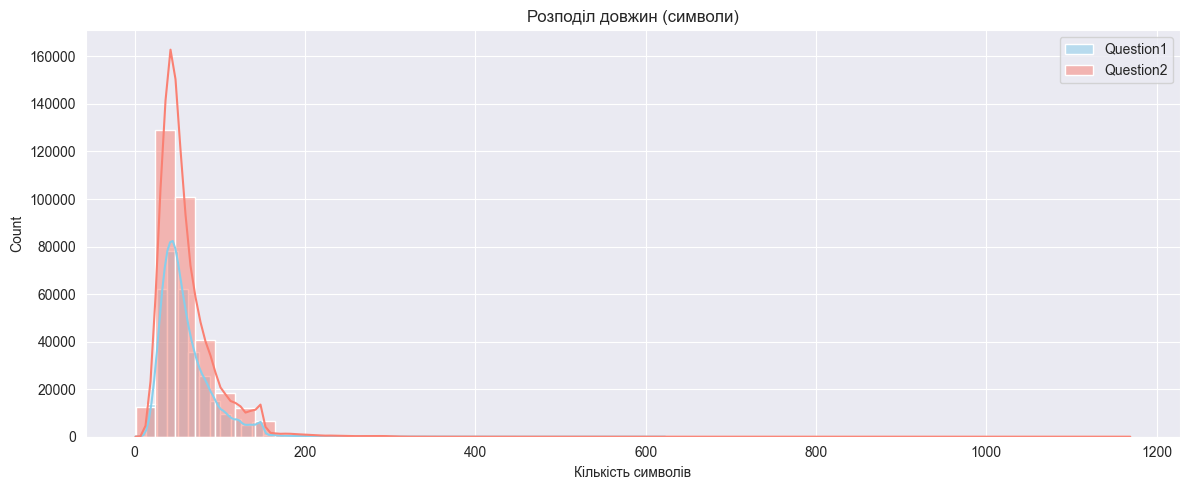

In [11]:
plt.figure(figsize=(12, 5))
sns.histplot(df['q1_len_chars'], bins=50, kde=True, color="skyblue", label='Question1')
sns.histplot(df['q2_len_chars'], bins=50, kde=True, color="salmon", label='Question2')
plt.title("Розподіл довжин (символи)")
plt.xlabel("Кількість символів")
plt.legend()

plt.tight_layout()
plt.show()

Спостереження:

- Бачимо, що більшість запитань є компактними, але є і певна частка довших запитань.
- Основна маса запитань має довжину до 100 символів, із вираженим піком у діапазоні 30–60 символів, що вказує на лаконічність формулювань.
- Спостерігається довгий правий хвіст, що відображає наявність окремих значно довших запитань (до ~1200 символів), однак таких прикладів дуже мало — це поодинокі винятки.


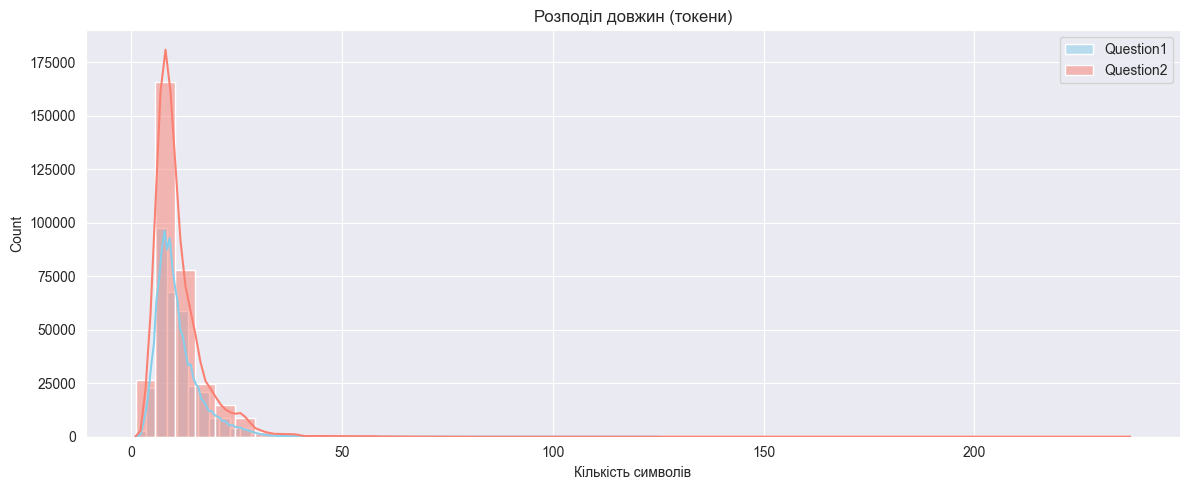

In [12]:
plt.figure(figsize=(12, 5))
sns.histplot(df['q1_len_words'], bins=50, kde=True, color="skyblue", label='Question1')
sns.histplot(df['q2_len_words'], bins=50, kde=True, color="salmon", label='Question2')
plt.title("Розподіл довжин (токени)")
plt.xlabel("Кількість символів")
plt.legend()

plt.tight_layout()
plt.show()

Спостереження:

- Можемо сказати, що довжин запитань за кількістю слів підтверджує, що більшість формулювань є стислими та мають однорідну структуру.
- Розподіли question1 та question2 практично ідентичні.
- Максимальні довжини окремих запитань досягають понад 200 слів, однак це поодинокі випадки, що формують довгий правий хвіст. Такі значення можуть бути пов’язані з надлишковими уточненнями або вставленими прикладами.

В цілому дана візуалізація дозволяє сформувати обґрунтовані обмеження при побудові вхідного шару для моделі (наприклад, усічення до 30–50 токенів).

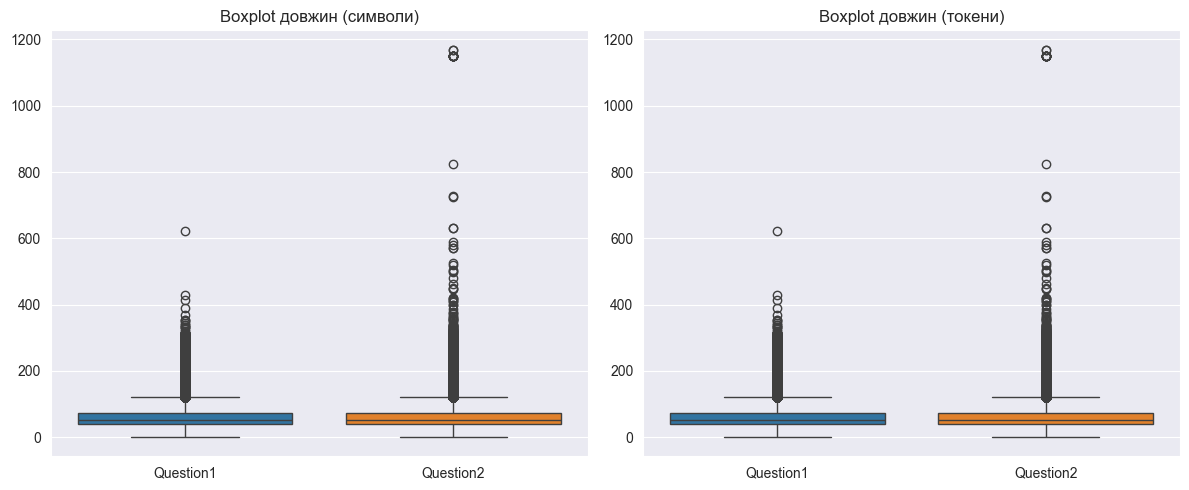

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df[['q1_len_chars', 'q2_len_chars']])
plt.title("Boxplot довжин (символи)")
plt.xticks([0, 1], ["Question1", "Question2"])

plt.subplot(1, 2, 2)
sns.boxplot(data=df[['q1_len_chars', 'q2_len_chars']])
plt.title("Boxplot довжин (токени)")
plt.xticks([0, 1], ["Question1", "Question2"])

plt.tight_layout()
plt.show()

In [14]:
print(df[['q1_len_chars', 'q2_len_chars']].describe())

        q1_len_chars   q2_len_chars
count  323432.000000  323432.000000
mean       59.531410      60.123083
std        29.921397      33.889916
min         1.000000       1.000000
25%        39.000000      39.000000
50%        52.000000      51.000000
75%        72.000000      72.000000
max       623.000000    1169.000000


#### Подивимось на загальну характеристику довжин запитань

In [15]:
length_features = {
    'q1_len_chars': df['question1'].astype(str).apply(len),
    'q2_len_chars': df['question2'].astype(str).apply(len),
    'q1_len_words': df['question1'].astype(str).apply(lambda x: len(x.split())),
    'q2_len_words': df['question2'].astype(str).apply(lambda x: len(x.split()))
}

length_df = pd.DataFrame(length_features)
stats = length_df.describe().T

pd.set_option('display.precision', 2)
stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]


,mean,std,min,25%,50%,75%,max
q1_len_chars,59.53,29.92,1.0,39.0,52.0,72.0,623.0
q2_len_chars,60.12,33.89,1.0,39.0,51.0,72.0,1169.0
q1_len_words,10.94,5.43,1.0,7.0,10.0,13.0,125.0
q2_len_words,11.18,6.31,1.0,7.0,10.0,13.0,237.0


Спостереження:

- Середня довжина запитань у символах становить приблизно 59–60 символів, при цьому медіана — 52 символи для question1 і 51 символ для question2. Це свідчить про лаконічність формулювань та їх відносну однорідність.
- Стандартне відхилення складає ~30–34 символи, що вказує на помірну варіативність довжин.
- Максимальна довжина для question2 — понад 1000 символів, що є нетиповим і формує довгий правий хвіст у розподілі.
- У словах середнє значення — близько 11 слів, з медіаною 10 слів для обох полів. Це відповідає типовим коротким запитанням.
- Верхній квартиль (75%) становить 13 слів, що дозволяє сформувати обґрунтовану верхню межу при побудові токенізованих векторів.

#### Порівняємо довжини між дублікатами і між не дублікатами

In [16]:
length_df['is_duplicate'] = df['is_duplicate']
avg_lengths = length_df.groupby('is_duplicate')[['q1_len_chars', 'q2_len_chars', 'q1_len_words', 'q2_len_words']].mean()

avg_lengths

,q1_len_chars,q2_len_chars,q1_len_words,q2_len_words
is_duplicate,,,,
0,63.45,64.34,11.58,11.96
1,52.83,52.92,9.85,9.86


Спостереження:

- У парах, позначених як недублікатні (is_duplicate = 0), запитання в середньому довші — близько 63–64 символів і 11.6 слів.
- Натомість у дублікатних парах (is_duplicate = 1), середня довжина менша — близько 52.8 символів і 9.8 слів.
- Це може свідчити про те, що коротші формулювання частіше є перефразуваннями або уточненнями однієї і тієї ж сутності, що логічно для дублікованих запитів.
- Таким чином, довжина запитань потенційно є релевантною ознакою для моделі, і може бути включена як одна з числових фіч.

## Аналіз токенів

In [19]:
df["processed_tokens_q1"] = df['question1'].apply(process_text)
all_tokens_q1 = df["processed_tokens_q1"].dropna().tolist()
flat_tokens_q1 = [token for sublist in all_tokens_q1 for token in sublist if token]

In [20]:
df["processed_tokens_q2"] = df['question2'].apply(process_text)
all_tokens_q2 = df["processed_tokens_q2"].dropna().tolist()
flat_tokens_q2 = [token for sublist in all_tokens_q2 for token in sublist if token]

In [23]:
analyzer_q1 = TokenFrequencyAnalyzer(flat_tokens_q1)
token_analyzed_q1 = analyzer_q1.to_dataframe()

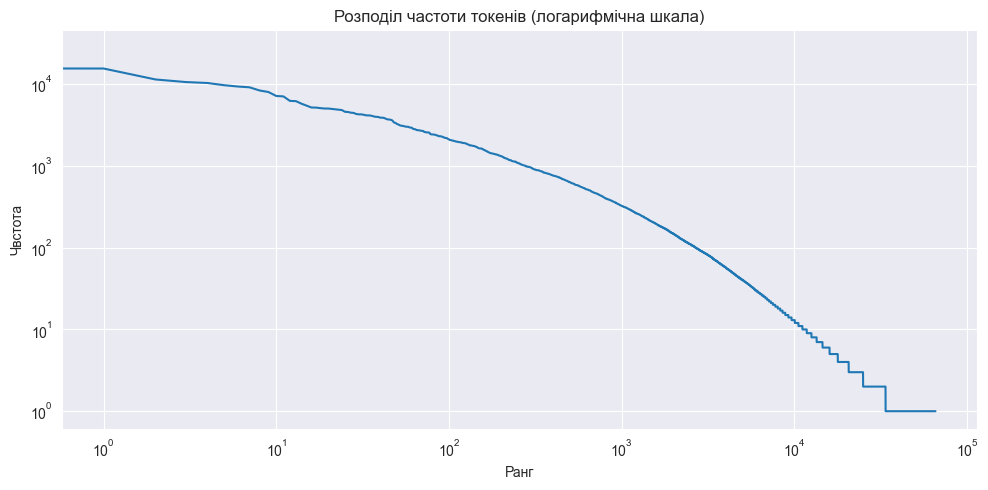

In [24]:
analyzer_q1.plot_distribution(loglog=True)

In [25]:
analyzer_q2 = TokenFrequencyAnalyzer(flat_tokens_q1)
token_analyzed_q2 = analyzer_q1.to_dataframe()

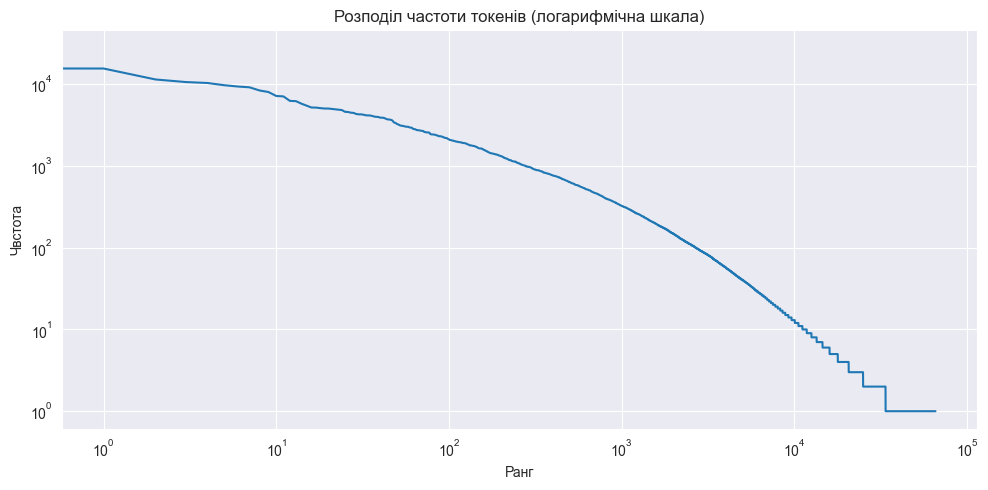

In [26]:
analyzer_q2.plot_distribution(loglog=True)

Спостереження:
- Спостерігається майже горизонтальне плато для рангів 1–10, що вказує на надзвичайно часті токени, які трапляються в корпусі десятки тисяч разів.
У діапазоні рангів 10–1000 фіксується плавний спад частот, що відповідає токенам середньої поширеності, які несуть потенційно важливу інформацію для моделі.
Починаючи з ~1000 рангу, крива різко знижується, частоти стають значно меншими — це вказує на наявність великої кількості рідкісних слів, що з’являються лише кілька разів у всьому наборі.

Можемо відкинути довгий “хвіст” малочастотних токенів, щоб зменшити розмірність векторного простору таусунути шум від рідкісних або несуттєвих слів зберігши при цьому високу інформативність ядра словника.
Для побудови базової моделі обґрунтовано встановити:
- min_df = 3 — виключення слів, які зустрічаються менш ніж у 3 документах;
- max_features = 4000 — використання найбільш значущих токенів, що формують основу змістовного наповнення корпусу.